# Google Colab (Skip locally)

In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/IFT6135/HW3_2025/src" #@param {type:"string"}
!ln -Ts "$folder" /content/src 2> /dev/null

# Add the assignment folder to Python path
if '/content/src' not in sys.path:
  sys.path.insert(0, '/content/src')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

# Imports & Setup

In [1]:
%matplotlib inline
import warnings
from shutil import make_archive
import os
import matplotlib.pyplot as plt
import torchvision
import torch

from q1_train_vae import experiment1
from q2_trainer_ddpm import experiment2
from q3_trainer_cfg import experiment3, show_save

models = ['VAE', 'DDPM', 'CFG']

# Experiments

## Experiment 1 (VAE)

In [9]:
vae_model, vae_optimizer = experiment1(False)

Loaded checkpoint from epoch 20


In [12]:
def generate_images(model, num_images: int = 64, device: torch.device = None) -> torch.Tensor:
    """
    Sample `num_images` from N(0,I) and decode them with a trained VAE.

    Args:
        model (nn.Module): trained VAE instance (with `decode(z)`).
        num_images (int): how many images to generate.
        device (torch.device, optional): where to run the sampling. 
            If None, inferred from model parameters.
    Returns:
        Tensor of shape (num_images, 1, 28, 28) with values in [0,1].
    """
    model.eval()
    # infer device if not provided
    if device is None:
        device = next(model.parameters()).device
    model.to(device)

    with torch.no_grad():
        # latent_dim = 20 for your VAE (fc21 out_features)
        latent_dim = model.fc21.out_features
        # sample from standard normal prior
        z = torch.randn(num_images, latent_dim, device=device)
        # decode and reshape
        recon_flat = model.decode(z)                     # (num_images, 784)
        images = recon_flat.view(num_images, 1, 28, 28)   # (num_images,1,28,28)

    return images

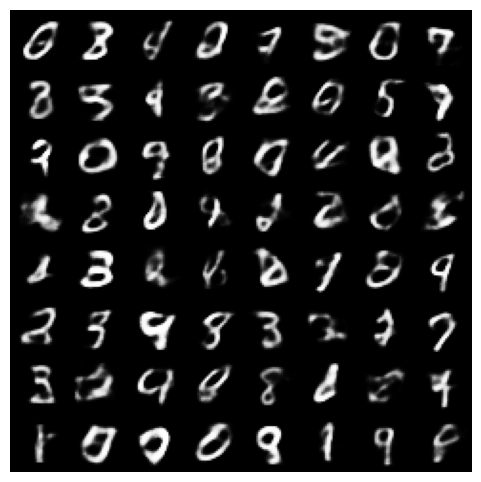

In [13]:
# generate 64 samples
samples = generate_images(vae_model, num_images=64)

# display as an 8×8 grid
grid = torchvision.utils.make_grid(samples, nrow=8, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# TODO make_archive('experiment1', 'zip', 'logs/experiment1')

## Experiment 2 (DDPM)

In [2]:
ddpm_trainer = experiment2(False)

No weights to load
[Checkpoint] Loaded model at epoch 19 from results/experiment2\checkpoints\ddpm_epoch_019.pt


Sampling: 100%|██████████| 248/248 [00:14<00:00, 17.37it/s]


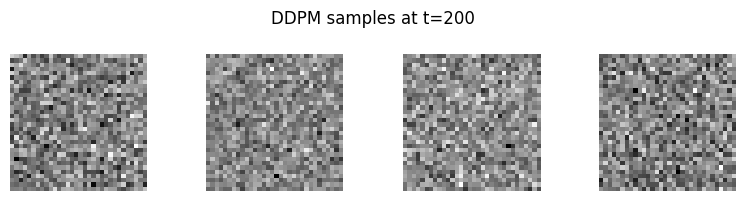

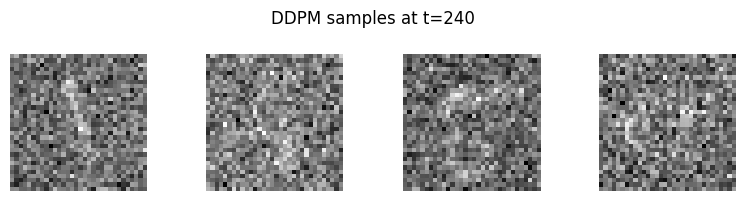

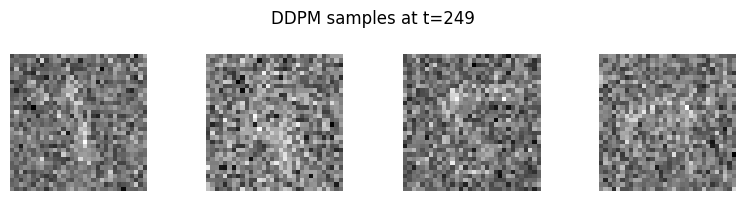

In [3]:
n_steps=250
steps_to_show = [200, 240, 249]  # whatever you used
images = ddpm_trainer.generate_intermediate_samples(
    n_steps=n_steps,
    n_samples=4,
    img_size=32,
    steps_to_show=steps_to_show,
    set_seed=True
)

# images is a list of numpy arrays, one per step in steps_to_show (plus the initial noise)
for img_array, step in zip(images, steps_to_show):
    # img_array.shape == (4, 1, H, W)
    fig, axes = plt.subplots(1, img_array.shape[0], figsize=(img_array.shape[0]*2,2))
    for i, ax in enumerate(axes):
        ax.imshow(img_array[i].squeeze(), cmap="gray")
        ax.axis("off")
    fig.suptitle(f"DDPM samples at t={step}")
    plt.tight_layout()
    plt.show()

In [ ]:
# TODO make_archive('experiment2', 'zip', 'logs/experiment2')

## Experiment 3 (CFG)

In [2]:
cfg_trainer = experiment3(False)

[Checkpoint] Loaded model at epoch 19 from results/experiment3\checkpoints\cfg_epoch_019.pt


250it [00:25,  9.74it/s]


Showing/saving samples from epoch 19 with labels: [1, 2, 4, 4, 2, 3, 3, 3, 4, 7, 6, 3, 5, 4, 4, 4]


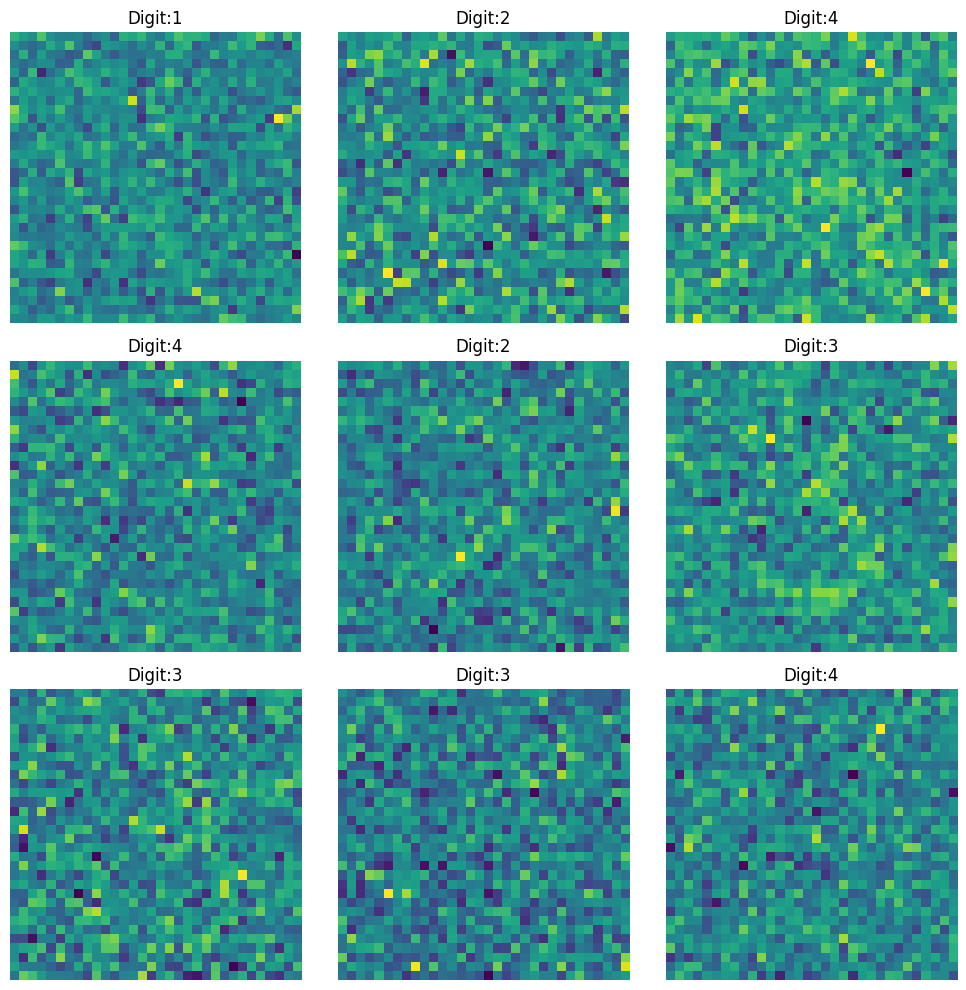

In [3]:
labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
n_steps        = 250     # number of diffusion steps

# 2. Generate samples
#    This returns a tensor of shape (n_samples, C, H, W)
samples = cfg_trainer.sample(n_steps=n_steps, show=True, save=False)


In [ ]:
# TODO make_archive('experiment3', 'zip', 'logs/experiment3')